# Dense Autoencoder with tied weights

In the previous notebook we have built an autoencoder with tied weights to reproduce the spectra. We have done this using only tensorflow. Now we are implementing the same architecture with Keras to make use of the built-in training callbacks, the history plotting options and the other features of Keras.

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
gen = np.loadtxt("qcs_gen10000.txt", delimiter=",")

#splitting data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=0.2, random_state=42, shuffle=True, stratify=None)

mean_train = np.mean(train, axis=1, dtype=np.float64)
mean_test = np.mean(test, axis=1, dtype=np.float64)
stddev_train = np.std(train, axis=1, dtype=np.float64)
stddev_test = np.std(test, axis=1, dtype=np.float64)

#standard scaling the training data
def standard_scale(X, m, s):
    return (X-m)/s

def rescale(X, m, s):
    return X*s+m

train = np.array([standard_scale(train[i], mean_train[i], stddev_train[i]) for i in range(len(train))])
test_scaled = np.array([standard_scale(test[i], mean_test[i], stddev_test[i]) for i in range(len(test))])

We define a new Layer class with tied weights:

In [26]:
#https://medium.com/@lmayrandprovencher/building-an-autoencoder-with-tied-weights-in-keras-c4a559c529a2 Abgerufen 02.11.2022
#From the book Hands-on machine learning with Scikit-Learn, Keras and Tensorflow, Chapter 17
#The code was outdated and needed to be fixed

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                               initializer="zeros",
                               shape=(self.dense.weights[0].shape[0],))
                               #shape=(batch_input_shape,)) #didn't work somehow
                               #shape=(self.dense.units,)) #is wrong, because the DenseTranspose 
                               #has as many nodes as the input of dense, not the output
                               #shape=[self.input_shape[-1]]) #was outdated
        super().build(batch_input_shape)
    def call(self, inputs):
        z=tf.matmul(inputs, self.dense.weights[0] , transpose_b=True) #transpose_b means, whether the second matrix should be transposed
        return self.activation(z+self.biases)

Defining the model:

In [27]:
activation = "elu"
regularizer = keras.regularizers.L1L2(l1=0.01, l2=0.01)

e1 = layers.Dense(500, activation=activation)
e2 = layers.Dense(250, activation=activation)
e3 = layers.Dense(100, activation=activation)
e4 = layers.Dense(25, activation=activation)
dropout = layers.Dropout(0.3)

encoder = keras.models.Sequential([layers.Input(shape=train.shape[1]), e1, e2, e3, e4], name="encoder")

decoder = keras.models.Sequential([DenseTranspose(e4, activation=activation),
                                  DenseTranspose(e3, activation=activation),
                                  DenseTranspose(e2, activation=activation),
                                  DenseTranspose(e1, activation=activation)], name="decoder")
                                   

model = keras.models.Sequential([encoder, decoder], name="autoencoder_dense_v2")

Compiling and fitting the model

In [28]:
model.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

In [29]:
results = model.fit(train,train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
57/57 - 1s - loss: 3.1520 - val_loss: 2.1585 - lr: 0.0100 - 1s/epoch - 19ms/step
Epoch 2/50
57/57 - 0s - loss: 2.0667 - val_loss: 2.0000 - lr: 0.0100 - 431ms/epoch - 8ms/step
Epoch 3/50
57/57 - 0s - loss: 2.0000 - val_loss: 2.0000 - lr: 0.0100 - 387ms/epoch - 7ms/step
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0066999998502433305.
57/57 - 0s - loss: 2.0000 - val_loss: 2.0000 - lr: 0.0100 - 421ms/epoch - 7ms/step
Epoch 4: early stopping


Let's see how the model performs

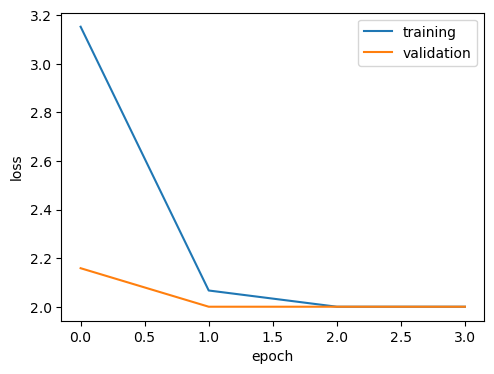

In [30]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

Visualizing some spectra

In [31]:
preds = model.predict(test_scaled, verbose=1)

63/63 [==============================] - 0s 2ms/step


In [32]:
#Rescaling the data for the plots. Using the StandardScaler from scikit would require to train it. We just do it manually.
preds_rescaled = [rescale(preds[i], mean_test[i], stddev_test[i]) for i in range(len(preds))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


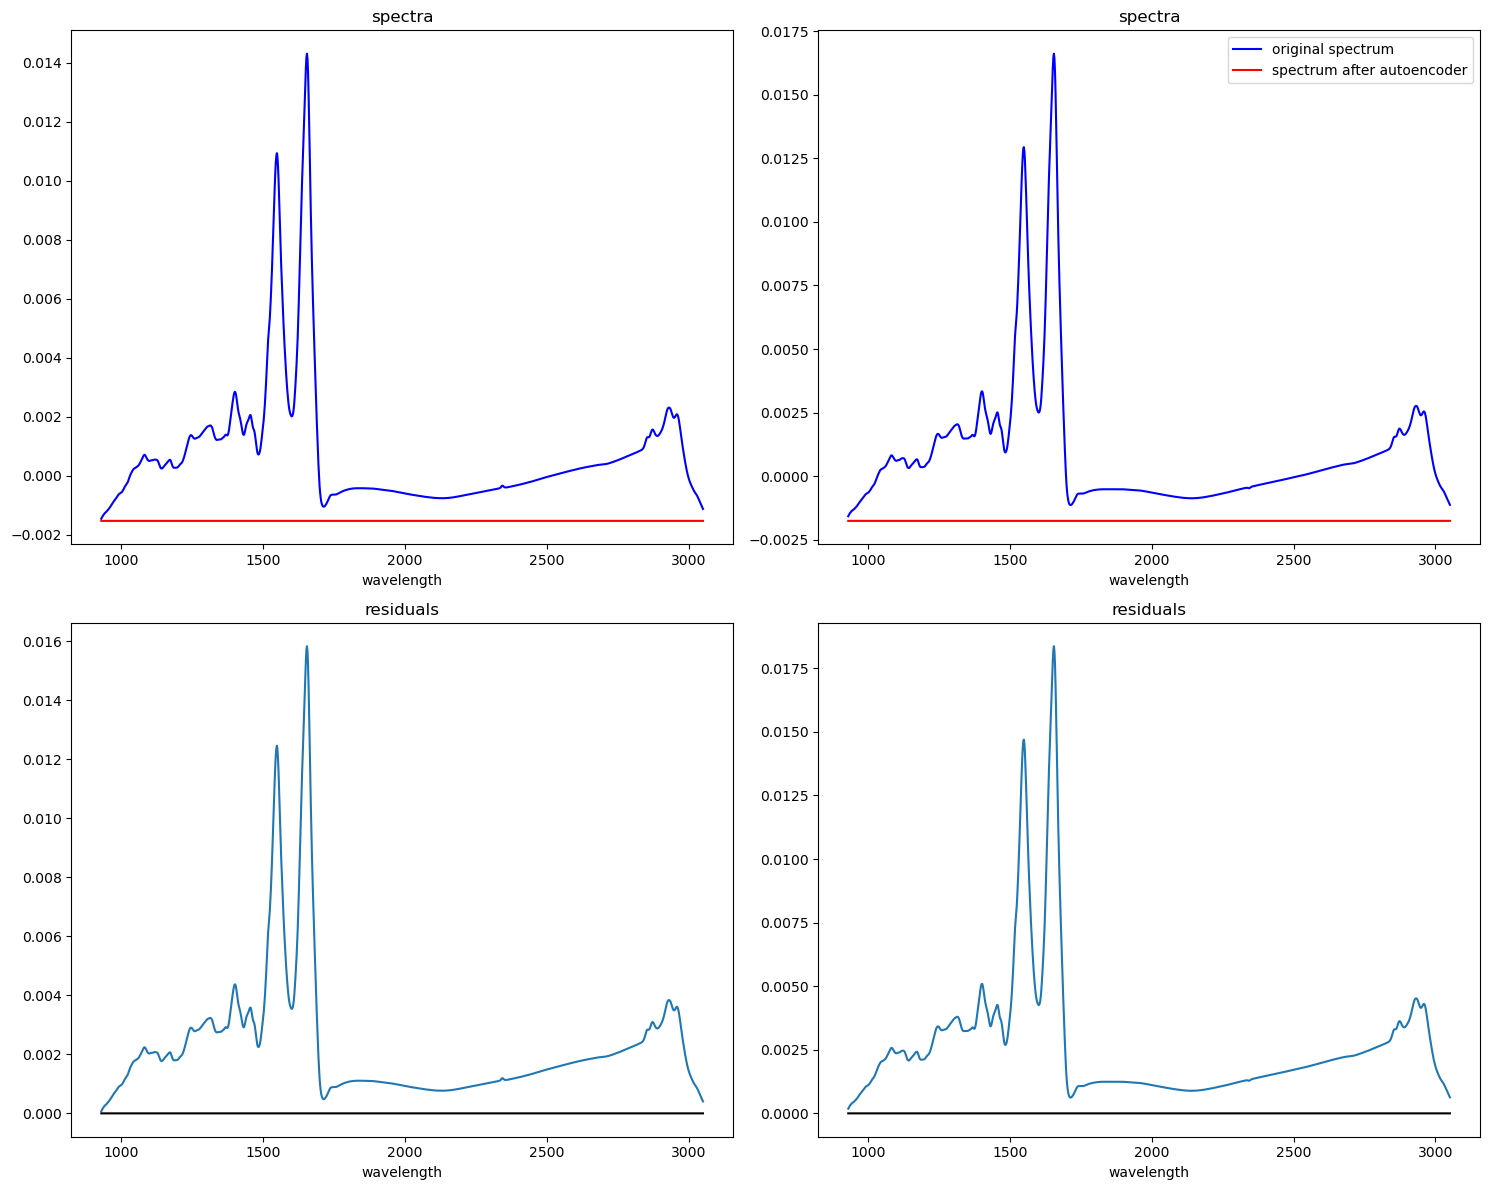

In [33]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', label="spectrum after autoencoder")
    ax1[1].legend(loc=1)
    ax1[i].set_xlabel('wavelength')
    ax2[i].set_xlabel('wavelength')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()

In [15]:
print(model.summary())

Model: "autoencoder_dense_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 25)                703875    
                                                                 
 decoder (Sequential)        (None, 1101)              705826    
                                                                 
Total params: 705,826
Trainable params: 705,826
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
#plt.savefig("dense_autoencoder2.png")
#model.save("dense_autoencoder2.h5")

Proof that the weights are really tied (i.e. have the same value):

In [12]:
print(sum(sum(abs(decoder.layers[0].get_weights()[0]-e4.get_weights()[0])))) # The sum of all residuals of the weight matrices
print(sum(sum(abs(decoder.layers[1].get_weights()[0]-e3.get_weights()[0]))))
print(sum(sum(abs(decoder.layers[2].get_weights()[0]-e2.get_weights()[0]))))
print(sum(sum(abs(decoder.layers[3].get_weights()[0]-e1.get_weights()[0]))))

ValueError: operands could not be broadcast together with shapes (100,) (100,25) 

In [ ]:
decoder.layers[0].get_weights()[0].shape

In [ ]:
e4.get_weights()[0].shape


## Debugging

This is my documentation of the debugging process of the DenseTranspose class. 

I am trying to discover, why the matrix multiplication in the DenseTranspose class (z) fails. 

In [ ]:
#encoder.build(train)
#encoded_debug = encoder.predict(train) #without training, because we only care for the dimensions

In [ ]:
#print(encoded_debug.shape) #This is the input shape for the first layer of the decoder (i.e. inputs in z)

Determining the shape of the weights of the last encoder layer, which should be self.dense.weights:

In [ ]:
print(encoder.layers[3].get_weights()[0].shape) #Weights for the input layer
print(encoder.layers[3].get_weights()[1].shape) # Biases for the input layer

In [ ]:
print(e4.get_weights()[0].shape)

Now investigating the decoder's layers. Update: They now (after some changes) seem to be correct (were before (50,), (100,), ...)

In [ ]:
print(decoder.layers[0].get_weights()[0].shape) #Weights for the first layer (should be [100,50])
print(decoder.layers[1].get_weights()[0].shape) #Weights for the second layer
print(decoder.layers[2].get_weights()[0].shape) #Weights for the third layer
print(decoder.layers[3].get_weights()[0].shape) #Weights for the fourth layer

Fixes: I think defining weights in the build()-Function fixed the issue, though I am not sure exactly why it was wrong before. Also the bias dimension has been outdated, so I set it to the row number of the weight matrix, which is exactly the number of nodes in the DenseTranspose layer.